<a href="https://colab.research.google.com/github/jxli0919/EECS_542_Practice/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torch import nn, optim
import torch.nn.functional as TF

#Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/Colab Notebooks/UNet

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/UNet


In [ ]:
ls

data/  params/  train_image/  UNet.ipynb


In [ ]:
def keep_image_size_open(path, size=(256, 256)):
    img = Image.open(path)
    temp = max(img.size)
    mask = Image.new('P', (temp, temp))
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask
def keep_image_size_open_rgb(path, size=(256, 256)):
    img = Image.open(path)
    temp = max(img.size)
    mask = Image.new('RGB', (temp, temp))
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
class MyDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.name = os.listdir(os.path.join(path, 'SegmentationClass'))

    def __len__(self):
        return len(self.name)

    def __getitem__(self, index):
        segment_name = self.name[index]  # xx.png
        segment_path = os.path.join(self.path, 'SegmentationClass', segment_name)
        image_path = os.path.join(self.path, 'JPEGImages', segment_name.replace('png','jpg'))
        segment_image = keep_image_size_open(segment_path)
        image = keep_image_size_open_rgb(image_path)
        return transform(image), torch.Tensor(np.array(segment_image))

In [ ]:
if __name__ == '__main__':
    from torch.nn.functional import one_hot
    data = MyDataset('data')
    print(data[0][0].shape)
    print(data[0][1].shape)
    out=one_hot(data[0][1].long())
    print(out.shape)

torch.Size([3, 256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 256])


#Unet

In [ ]:
class Conv_Block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(Conv_Block, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)



In [ ]:
class DownSample(nn.Module):
    def __init__(self,channel):
        super(DownSample, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)


class UpSample(nn.Module):
    def __init__(self,channel):
        super(UpSample, self).__init__()
        self.layer=nn.Conv2d(channel,channel//2,1,1)
    def forward(self,x,feature_map):
        up=TF.interpolate(x,scale_factor=2,mode='nearest')
        out=self.layer(up)
        return torch.cat((out,feature_map),dim=1)



In [ ]:
class UNet(nn.Module):
    def __init__(self,num_classes):
        super(UNet, self).__init__()
        self.c1=Conv_Block(3,64)
        self.d1=DownSample(64)
        self.c2=Conv_Block(64,128)
        self.d2=DownSample(128)
        self.c3=Conv_Block(128,256)
        self.d3=DownSample(256)
        self.c4=Conv_Block(256,512)
        self.d4=DownSample(512)
        self.c5=Conv_Block(512,1024)
        self.u1=UpSample(1024)
        self.c6=Conv_Block(1024,512)
        self.u2 = UpSample(512)
        self.c7 = Conv_Block(512, 256)
        self.u3 = UpSample(256)
        self.c8 = Conv_Block(256, 128)
        self.u4 = UpSample(128)
        self.c9 = Conv_Block(128, 64)
        self.out=nn.Conv2d(64,num_classes,3,1,1)

    def forward(self,x):
        R1=self.c1(x)
        R2=self.c2(self.d1(R1))
        R3 = self.c3(self.d2(R2))
        R4 = self.c4(self.d3(R3))
        R5 = self.c5(self.d4(R4))
        O1=self.c6(self.u1(R5,R4))
        O2 = self.c7(self.u2(O1, R3))
        O3 = self.c8(self.u3(O2, R2))
        O4 = self.c9(self.u4(O3, R1))

        return self.out(O4)

In [ ]:
if __name__ == '__main__':
    x=torch.randn(2,3,256,256)
    net=UNet(num_classes=3)
    print(net(x).shape)

torch.Size([2, 3, 256, 256])


#Train

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_path = 'params/unet.pth'
data_path = 'data'
save_path = 'train_image'
if __name__ == '__main__':
    num_classes = 1+255  # +1 for background
    data_loader = DataLoader(MyDataset(data_path), batch_size=1, shuffle=True)
    net = UNet(num_classes).to(device)
    if os.path.exists(weight_path):
        net.load_state_dict(torch.load(weight_path))
        print('successful load weight！')
    else:
        print('not successful load weight')

    opt = optim.Adam(net.parameters())
    loss_fun = nn.CrossEntropyLoss()

    epoch = 1
    while epoch < 3:#200
        for i, (image, segment_image) in enumerate(tqdm.tqdm(data_loader)):
            image, segment_image = image.to(device), segment_image.to(device)
            out_image = net(image)
            train_loss = loss_fun(out_image, segment_image.long())
            opt.zero_grad()
            train_loss.backward()
            opt.step()

            if i % 1 == 0:
                print(f'{epoch}-{i}-train_loss===>>{train_loss.item()}')

            _image = image[0]
            _segment_image = torch.unsqueeze(segment_image[0], 0) * 255
            _out_image = torch.argmax(out_image[0], dim=0).unsqueeze(0) * 255

            img = torch.stack([_segment_image, _out_image], dim=0)
            save_image(img, f'{save_path}/{i}.png')
        if epoch % 2 == 0:#20
            torch.save(net.state_dict(), weight_path)
            print('save successfully!')
        epoch += 1

not successful load weight


  0%|          | 0/422 [00:00<?, ?it/s]

1-0-train_loss===>>5.838018894195557


  0%|          | 1/422 [00:03<26:56,  3.84s/it]

1-1-train_loss===>>5.423799991607666


  0%|          | 2/422 [00:06<21:31,  3.07s/it]

1-2-train_loss===>>5.12255859375


  1%|          | 3/422 [00:08<19:06,  2.74s/it]

1-3-train_loss===>>4.966447830200195


  1%|          | 4/422 [00:13<25:26,  3.65s/it]

1-4-train_loss===>>4.277888298034668


  1%|          | 5/422 [00:15<20:21,  2.93s/it]

1-5-train_loss===>>3.602337598800659


  1%|▏         | 6/422 [00:17<17:21,  2.50s/it]

1-6-train_loss===>>3.5144240856170654


  2%|▏         | 7/422 [00:18<15:44,  2.28s/it]

1-7-train_loss===>>3.4125092029571533


  2%|▏         | 8/422 [00:20<14:43,  2.13s/it]

1-8-train_loss===>>3.0916056632995605


  2%|▏         | 9/422 [00:22<14:21,  2.09s/it]

1-9-train_loss===>>2.741668224334717


  2%|▏         | 10/422 [00:24<13:13,  1.93s/it]

1-10-train_loss===>>2.8296308517456055


  3%|▎         | 11/422 [00:26<12:57,  1.89s/it]

1-11-train_loss===>>2.129546642303467


  3%|▎         | 12/422 [00:27<12:34,  1.84s/it]

1-12-train_loss===>>1.7341270446777344


  3%|▎         | 13/422 [00:29<12:26,  1.82s/it]

1-13-train_loss===>>1.8704845905303955


  3%|▎         | 14/422 [00:31<11:44,  1.73s/it]

1-14-train_loss===>>1.473799705505371


  4%|▎         | 15/422 [00:32<11:20,  1.67s/it]

1-15-train_loss===>>1.077863335609436


  4%|▍         | 16/422 [00:34<11:29,  1.70s/it]

1-16-train_loss===>>1.855656385421753


  4%|▍         | 17/422 [00:35<11:01,  1.63s/it]

1-17-train_loss===>>1.6973726749420166


  4%|▍         | 18/422 [00:37<11:09,  1.66s/it]

1-18-train_loss===>>1.1509053707122803


  5%|▍         | 19/422 [00:39<11:15,  1.68s/it]

1-19-train_loss===>>1.6191620826721191


  5%|▍         | 20/422 [00:41<11:33,  1.72s/it]

1-20-train_loss===>>0.8663603067398071


  5%|▍         | 21/422 [00:42<11:07,  1.67s/it]

1-21-train_loss===>>1.9387164115905762


  5%|▌         | 22/422 [00:44<10:57,  1.64s/it]

1-22-train_loss===>>1.052137017250061


  5%|▌         | 23/422 [00:45<10:37,  1.60s/it]

1-23-train_loss===>>1.404571771621704


  6%|▌         | 24/422 [00:47<10:36,  1.60s/it]

1-24-train_loss===>>2.3512163162231445


  6%|▌         | 25/422 [00:48<10:37,  1.61s/it]

1-25-train_loss===>>1.6442105770111084


  6%|▌         | 26/422 [00:50<10:55,  1.66s/it]

1-26-train_loss===>>2.374727249145508


  6%|▋         | 27/422 [00:52<10:52,  1.65s/it]

1-27-train_loss===>>1.315264105796814


  7%|▋         | 28/422 [00:54<10:55,  1.66s/it]

1-28-train_loss===>>2.097515344619751


  7%|▋         | 29/422 [00:55<11:17,  1.72s/it]

1-29-train_loss===>>0.5964828133583069


  7%|▋         | 30/422 [00:57<11:25,  1.75s/it]

1-30-train_loss===>>2.3972809314727783


  7%|▋         | 31/422 [00:59<10:56,  1.68s/it]

1-31-train_loss===>>0.8574984669685364


  8%|▊         | 32/422 [01:00<10:37,  1.63s/it]

1-32-train_loss===>>1.1577775478363037


  8%|▊         | 33/422 [01:02<10:39,  1.64s/it]

1-33-train_loss===>>1.246459722518921


  8%|▊         | 34/422 [01:04<10:46,  1.67s/it]

1-34-train_loss===>>1.0699633359909058


  8%|▊         | 35/422 [01:05<10:54,  1.69s/it]

1-35-train_loss===>>1.313185691833496


  9%|▊         | 36/422 [01:07<10:59,  1.71s/it]

1-36-train_loss===>>2.9214208126068115


  9%|▉         | 37/422 [01:09<10:36,  1.65s/it]

1-37-train_loss===>>0.4337741732597351


  9%|▉         | 38/422 [01:10<10:35,  1.65s/it]

1-38-train_loss===>>0.5140564441680908


  9%|▉         | 39/422 [01:12<10:54,  1.71s/it]

1-39-train_loss===>>0.9990200996398926


  9%|▉         | 40/422 [01:14<11:05,  1.74s/it]

1-40-train_loss===>>0.5919151306152344


 10%|▉         | 41/422 [01:16<10:50,  1.71s/it]

1-41-train_loss===>>1.1514618396759033


 10%|▉         | 42/422 [01:17<11:01,  1.74s/it]

1-42-train_loss===>>0.24040356278419495


 10%|█         | 43/422 [01:19<10:52,  1.72s/it]

1-43-train_loss===>>1.1132001876831055


 10%|█         | 44/422 [01:21<10:29,  1.67s/it]

1-44-train_loss===>>1.9576557874679565


 11%|█         | 45/422 [01:22<10:32,  1.68s/it]

1-45-train_loss===>>1.4422460794448853


 11%|█         | 46/422 [01:24<10:51,  1.73s/it]

1-46-train_loss===>>1.9923220872879028


 11%|█         | 47/422 [01:26<10:58,  1.76s/it]

1-47-train_loss===>>0.7005980014801025


 11%|█▏        | 48/422 [01:28<11:02,  1.77s/it]

1-48-train_loss===>>0.9231829047203064


 12%|█▏        | 49/422 [01:30<10:56,  1.76s/it]

1-49-train_loss===>>2.480579137802124


 12%|█▏        | 50/422 [01:32<11:10,  1.80s/it]

1-50-train_loss===>>0.8922673463821411


 12%|█▏        | 51/422 [01:33<11:04,  1.79s/it]

1-51-train_loss===>>0.8535741567611694


 12%|█▏        | 52/422 [01:35<10:30,  1.70s/it]

1-52-train_loss===>>0.19167391955852509


 13%|█▎        | 53/422 [01:36<10:27,  1.70s/it]

1-53-train_loss===>>0.9923363327980042


 13%|█▎        | 54/422 [01:38<10:45,  1.75s/it]

1-54-train_loss===>>1.0707125663757324


 13%|█▎        | 55/422 [01:40<10:27,  1.71s/it]

1-55-train_loss===>>1.5267143249511719


 13%|█▎        | 56/422 [01:42<10:24,  1.71s/it]

1-56-train_loss===>>1.7772216796875


 14%|█▎        | 57/422 [01:43<10:36,  1.74s/it]

1-57-train_loss===>>0.6869628429412842


 14%|█▎        | 58/422 [01:45<10:23,  1.71s/it]

1-58-train_loss===>>1.4037246704101562


 14%|█▍        | 59/422 [01:47<10:09,  1.68s/it]

1-59-train_loss===>>2.297762393951416


 14%|█▍        | 60/422 [01:48<10:07,  1.68s/it]

1-60-train_loss===>>0.5721101760864258


 14%|█▍        | 61/422 [01:50<09:52,  1.64s/it]

1-61-train_loss===>>0.5060835480690002


 15%|█▍        | 62/422 [01:52<10:02,  1.67s/it]

1-62-train_loss===>>1.1531330347061157


 15%|█▍        | 63/422 [01:53<09:41,  1.62s/it]

1-63-train_loss===>>0.560600221157074


 15%|█▌        | 64/422 [01:55<09:47,  1.64s/it]

1-64-train_loss===>>0.9373193383216858


 15%|█▌        | 65/422 [01:57<09:44,  1.64s/it]

1-65-train_loss===>>0.6123125553131104


 16%|█▌        | 66/422 [01:58<09:56,  1.68s/it]

1-66-train_loss===>>1.6723203659057617


 16%|█▌        | 67/422 [02:00<09:54,  1.67s/it]

1-67-train_loss===>>0.47365349531173706


 16%|█▌        | 68/422 [02:02<09:54,  1.68s/it]

1-68-train_loss===>>0.6447387337684631


 16%|█▋        | 69/422 [02:03<10:10,  1.73s/it]

1-69-train_loss===>>2.74362850189209


 17%|█▋        | 70/422 [02:05<09:22,  1.60s/it]

1-70-train_loss===>>1.6046040058135986


 17%|█▋        | 71/422 [02:07<09:45,  1.67s/it]

1-71-train_loss===>>2.2890288829803467


 17%|█▋        | 72/422 [02:08<10:02,  1.72s/it]

1-72-train_loss===>>1.6702474355697632


 17%|█▋        | 73/422 [02:10<09:42,  1.67s/it]

1-73-train_loss===>>0.7160956263542175


 18%|█▊        | 74/422 [02:12<09:43,  1.68s/it]

1-74-train_loss===>>1.6857237815856934


 18%|█▊        | 75/422 [02:13<09:49,  1.70s/it]

1-75-train_loss===>>1.6863930225372314


 18%|█▊        | 76/422 [02:15<09:59,  1.73s/it]

1-76-train_loss===>>0.6572211384773254


 18%|█▊        | 77/422 [02:17<09:56,  1.73s/it]

1-77-train_loss===>>3.288363456726074


 18%|█▊        | 78/422 [02:19<09:53,  1.73s/it]

1-78-train_loss===>>3.3373353481292725


 19%|█▊        | 79/422 [02:21<10:02,  1.76s/it]

1-79-train_loss===>>1.5518465042114258


 19%|█▉        | 80/422 [02:22<10:03,  1.77s/it]

1-80-train_loss===>>1.3819808959960938


 19%|█▉        | 81/422 [02:24<10:13,  1.80s/it]

1-81-train_loss===>>1.115264654159546


 19%|█▉        | 82/422 [02:26<09:44,  1.72s/it]

1-82-train_loss===>>2.4135873317718506


 20%|█▉        | 83/422 [02:27<09:16,  1.64s/it]

1-83-train_loss===>>1.7792503833770752


 20%|█▉        | 84/422 [02:29<09:28,  1.68s/it]

1-84-train_loss===>>1.262468695640564


 20%|██        | 85/422 [02:31<09:15,  1.65s/it]

1-85-train_loss===>>0.6019291281700134


 20%|██        | 86/422 [02:32<09:32,  1.70s/it]

1-86-train_loss===>>2.6600165367126465


 21%|██        | 87/422 [02:34<09:31,  1.70s/it]

1-87-train_loss===>>0.38418975472450256


 21%|██        | 88/422 [02:36<09:42,  1.74s/it]

1-88-train_loss===>>1.007723331451416


 21%|██        | 89/422 [02:38<09:58,  1.80s/it]

1-89-train_loss===>>0.6111783981323242


 21%|██▏       | 90/422 [02:40<10:11,  1.84s/it]

1-90-train_loss===>>0.7825350761413574


 22%|██▏       | 91/422 [02:42<10:13,  1.85s/it]

1-91-train_loss===>>0.6334157586097717


 22%|██▏       | 92/422 [02:43<10:10,  1.85s/it]

1-92-train_loss===>>0.43641197681427


 22%|██▏       | 93/422 [02:46<10:30,  1.92s/it]

1-93-train_loss===>>0.9580365419387817


 22%|██▏       | 94/422 [02:47<10:09,  1.86s/it]

1-94-train_loss===>>0.3150200843811035


 23%|██▎       | 95/422 [02:49<10:18,  1.89s/it]

1-95-train_loss===>>1.4614529609680176


 23%|██▎       | 96/422 [02:51<09:43,  1.79s/it]

1-96-train_loss===>>1.4216766357421875


 23%|██▎       | 97/422 [02:53<09:33,  1.76s/it]

1-97-train_loss===>>0.6110315322875977


 23%|██▎       | 98/422 [02:54<09:22,  1.74s/it]

1-98-train_loss===>>0.9928070306777954


 23%|██▎       | 99/422 [02:56<09:21,  1.74s/it]

1-99-train_loss===>>1.164035677909851


 24%|██▎       | 100/422 [02:58<09:21,  1.74s/it]

1-100-train_loss===>>0.38423416018486023


 24%|██▍       | 101/422 [02:59<09:19,  1.74s/it]

1-101-train_loss===>>1.2970173358917236


 24%|██▍       | 102/422 [03:01<09:21,  1.75s/it]

1-102-train_loss===>>0.5689396858215332


 24%|██▍       | 103/422 [03:03<09:43,  1.83s/it]

1-103-train_loss===>>0.3564276695251465


 25%|██▍       | 104/422 [03:05<09:32,  1.80s/it]

1-104-train_loss===>>0.9642334580421448


 25%|██▍       | 105/422 [03:06<08:57,  1.69s/it]

1-105-train_loss===>>1.1400561332702637


 25%|██▌       | 106/422 [03:08<09:13,  1.75s/it]

1-106-train_loss===>>0.2473597377538681


 25%|██▌       | 107/422 [03:10<09:17,  1.77s/it]

1-107-train_loss===>>1.0946485996246338


 26%|██▌       | 108/422 [03:12<09:12,  1.76s/it]

1-108-train_loss===>>2.502531051635742


 26%|██▌       | 109/422 [03:14<09:18,  1.78s/it]

1-109-train_loss===>>2.068220376968384


 26%|██▌       | 110/422 [03:15<09:12,  1.77s/it]

1-110-train_loss===>>1.1045842170715332


 26%|██▋       | 111/422 [03:17<08:48,  1.70s/it]

1-111-train_loss===>>0.1916050910949707


 27%|██▋       | 112/422 [03:18<08:08,  1.58s/it]

1-112-train_loss===>>2.1235737800598145


 27%|██▋       | 113/422 [03:20<08:16,  1.61s/it]

1-113-train_loss===>>1.085424542427063


 27%|██▋       | 114/422 [03:21<08:05,  1.58s/it]

1-114-train_loss===>>0.33938223123550415


 27%|██▋       | 115/422 [03:23<08:19,  1.63s/it]

1-115-train_loss===>>0.7957068681716919


 27%|██▋       | 116/422 [03:25<08:36,  1.69s/it]

1-116-train_loss===>>0.4914388656616211


 28%|██▊       | 117/422 [03:27<08:43,  1.72s/it]

1-117-train_loss===>>1.983705997467041


 28%|██▊       | 118/422 [03:29<08:44,  1.73s/it]

1-118-train_loss===>>1.491049885749817


 28%|██▊       | 119/422 [03:31<09:29,  1.88s/it]

1-119-train_loss===>>0.22924622893333435


 28%|██▊       | 120/422 [03:33<09:19,  1.85s/it]

1-120-train_loss===>>0.9368923902511597


 29%|██▊       | 121/422 [03:34<09:05,  1.81s/it]

1-121-train_loss===>>0.44542187452316284


 29%|██▉       | 122/422 [03:36<09:04,  1.82s/it]

1-122-train_loss===>>0.7725142240524292


 29%|██▉       | 123/422 [03:38<08:54,  1.79s/it]

1-123-train_loss===>>1.8970426321029663


 29%|██▉       | 124/422 [03:40<08:46,  1.77s/it]

1-124-train_loss===>>2.098719358444214


 30%|██▉       | 125/422 [03:41<08:30,  1.72s/it]

1-125-train_loss===>>1.821102261543274


 30%|██▉       | 126/422 [03:43<08:35,  1.74s/it]

1-126-train_loss===>>1.618485450744629


 30%|███       | 127/422 [03:45<08:36,  1.75s/it]

1-127-train_loss===>>1.9479671716690063


 30%|███       | 128/422 [03:46<08:34,  1.75s/it]

1-128-train_loss===>>0.9222095012664795


 31%|███       | 129/422 [03:48<08:33,  1.75s/it]

1-129-train_loss===>>1.5510179996490479


 31%|███       | 130/422 [03:50<08:12,  1.69s/it]

1-130-train_loss===>>1.3549199104309082


 31%|███       | 131/422 [03:52<08:19,  1.72s/it]

1-131-train_loss===>>1.458451747894287


 31%|███▏      | 132/422 [03:54<09:11,  1.90s/it]

1-132-train_loss===>>1.6797055006027222


 32%|███▏      | 133/422 [03:56<09:09,  1.90s/it]

1-133-train_loss===>>0.871503472328186


 32%|███▏      | 134/422 [03:58<08:56,  1.86s/it]

1-134-train_loss===>>1.029929518699646


 32%|███▏      | 135/422 [03:59<08:31,  1.78s/it]

1-135-train_loss===>>0.8455404043197632


 32%|███▏      | 136/422 [04:01<08:34,  1.80s/it]

1-136-train_loss===>>1.0157800912857056


 32%|███▏      | 137/422 [04:03<08:26,  1.78s/it]

1-137-train_loss===>>2.7260704040527344


 33%|███▎      | 138/422 [04:04<08:22,  1.77s/it]

1-138-train_loss===>>0.17583221197128296


 33%|███▎      | 139/422 [04:06<08:19,  1.77s/it]

1-139-train_loss===>>0.9153998494148254


 33%|███▎      | 140/422 [04:08<08:07,  1.73s/it]

1-140-train_loss===>>0.7557305097579956


 33%|███▎      | 141/422 [04:09<07:52,  1.68s/it]

1-141-train_loss===>>1.263053297996521


 34%|███▎      | 142/422 [04:11<07:53,  1.69s/it]

1-142-train_loss===>>2.0968000888824463


 34%|███▍      | 143/422 [04:13<07:40,  1.65s/it]

1-143-train_loss===>>1.8228981494903564


 34%|███▍      | 144/422 [04:14<07:44,  1.67s/it]

1-144-train_loss===>>0.4924654960632324


 34%|███▍      | 145/422 [04:16<07:44,  1.68s/it]

1-145-train_loss===>>0.8687529563903809


 35%|███▍      | 146/422 [04:18<07:31,  1.64s/it]

1-146-train_loss===>>0.8677234053611755


 35%|███▍      | 147/422 [04:19<07:45,  1.69s/it]

1-147-train_loss===>>0.17930322885513306


 35%|███▌      | 148/422 [04:21<07:49,  1.71s/it]

1-148-train_loss===>>1.663459062576294


 35%|███▌      | 149/422 [04:23<07:50,  1.72s/it]

1-149-train_loss===>>3.017083168029785


 36%|███▌      | 150/422 [04:25<07:38,  1.69s/it]

1-150-train_loss===>>1.135192632675171


 36%|███▌      | 151/422 [04:26<07:39,  1.70s/it]

1-151-train_loss===>>1.0397181510925293


 36%|███▌      | 152/422 [04:28<07:50,  1.74s/it]

1-152-train_loss===>>0.20641958713531494


 36%|███▋      | 153/422 [04:30<07:30,  1.68s/it]

1-153-train_loss===>>1.9737122058868408


 36%|███▋      | 154/422 [04:31<07:40,  1.72s/it]

1-154-train_loss===>>1.0073364973068237


 37%|███▋      | 155/422 [04:33<07:34,  1.70s/it]

1-155-train_loss===>>0.5939193964004517


 37%|███▋      | 156/422 [04:35<07:29,  1.69s/it]

1-156-train_loss===>>1.6405283212661743


 37%|███▋      | 157/422 [04:37<07:35,  1.72s/it]

1-157-train_loss===>>0.7157498598098755


 37%|███▋      | 158/422 [04:38<07:24,  1.69s/it]

1-158-train_loss===>>0.7126979231834412


 38%|███▊      | 159/422 [04:40<07:38,  1.74s/it]

1-159-train_loss===>>1.3326773643493652


 38%|███▊      | 160/422 [04:42<07:39,  1.75s/it]

1-160-train_loss===>>1.0816549062728882


 38%|███▊      | 161/422 [04:44<07:35,  1.75s/it]

1-161-train_loss===>>0.9812244176864624


 38%|███▊      | 162/422 [04:45<07:39,  1.77s/it]

1-162-train_loss===>>1.5745928287506104


 39%|███▊      | 163/422 [04:47<07:42,  1.78s/it]

1-163-train_loss===>>0.5275928974151611


 39%|███▉      | 164/422 [04:49<07:27,  1.74s/it]

1-164-train_loss===>>0.7565579414367676


 39%|███▉      | 165/422 [04:51<07:29,  1.75s/it]

1-165-train_loss===>>0.6537267565727234


 39%|███▉      | 166/422 [04:52<07:35,  1.78s/it]

1-166-train_loss===>>2.2805464267730713


 40%|███▉      | 167/422 [04:54<07:33,  1.78s/it]

1-167-train_loss===>>1.1235733032226562


 40%|███▉      | 168/422 [04:56<07:37,  1.80s/it]

1-168-train_loss===>>0.5170196294784546


 40%|████      | 169/422 [04:58<07:39,  1.82s/it]

1-169-train_loss===>>0.9731574654579163


 40%|████      | 170/422 [05:00<07:40,  1.83s/it]

1-170-train_loss===>>1.6648176908493042


 41%|████      | 171/422 [05:02<07:46,  1.86s/it]

1-171-train_loss===>>0.8294088840484619


 41%|████      | 172/422 [05:04<07:40,  1.84s/it]

1-172-train_loss===>>1.4539222717285156


 41%|████      | 173/422 [05:05<07:31,  1.81s/it]

1-173-train_loss===>>0.4754226803779602


 41%|████      | 174/422 [05:07<06:51,  1.66s/it]

1-174-train_loss===>>1.0843929052352905


 41%|████▏     | 175/422 [05:08<06:52,  1.67s/it]

1-175-train_loss===>>2.5717225074768066


 42%|████▏     | 176/422 [05:10<06:42,  1.64s/it]

1-176-train_loss===>>2.9455854892730713


 42%|████▏     | 177/422 [05:12<06:48,  1.67s/it]

1-177-train_loss===>>4.461557865142822


 42%|████▏     | 178/422 [05:13<06:43,  1.65s/it]

1-178-train_loss===>>1.3053292036056519


 42%|████▏     | 179/422 [05:15<06:15,  1.54s/it]

1-179-train_loss===>>1.5165040493011475


 43%|████▎     | 180/422 [05:16<06:23,  1.58s/it]

1-180-train_loss===>>0.7790749073028564


 43%|████▎     | 181/422 [05:18<06:43,  1.67s/it]

1-181-train_loss===>>0.6903809905052185


 43%|████▎     | 182/422 [05:20<06:42,  1.68s/it]

1-182-train_loss===>>0.9963846206665039


 43%|████▎     | 183/422 [05:21<06:12,  1.56s/it]

1-183-train_loss===>>0.825969934463501


 44%|████▎     | 184/422 [05:23<06:19,  1.60s/it]

1-184-train_loss===>>1.0624279975891113


 44%|████▍     | 185/422 [05:24<06:20,  1.60s/it]

1-185-train_loss===>>0.5424405336380005


 44%|████▍     | 186/422 [05:26<06:29,  1.65s/it]

1-186-train_loss===>>0.9074524641036987


 44%|████▍     | 187/422 [05:27<06:01,  1.54s/it]

1-187-train_loss===>>1.2919375896453857


 45%|████▍     | 188/422 [05:29<06:20,  1.62s/it]

1-188-train_loss===>>2.7573723793029785


 45%|████▍     | 189/422 [05:31<06:22,  1.64s/it]

1-189-train_loss===>>1.451676607131958


 45%|████▌     | 190/422 [05:32<05:56,  1.54s/it]

1-190-train_loss===>>1.8329546451568604


 45%|████▌     | 191/422 [05:34<05:53,  1.53s/it]

1-191-train_loss===>>0.913821280002594


 45%|████▌     | 192/422 [05:35<06:03,  1.58s/it]

1-192-train_loss===>>2.4172542095184326


 46%|████▌     | 193/422 [05:37<06:12,  1.63s/it]

1-193-train_loss===>>0.5463235378265381


 46%|████▌     | 194/422 [05:39<06:20,  1.67s/it]

1-194-train_loss===>>1.3651206493377686


 46%|████▌     | 195/422 [05:40<06:07,  1.62s/it]

1-195-train_loss===>>1.7119909524917603


 46%|████▋     | 196/422 [05:42<06:09,  1.63s/it]

1-196-train_loss===>>0.805575966835022


 47%|████▋     | 197/422 [05:44<06:12,  1.66s/it]

1-197-train_loss===>>2.6457505226135254


 47%|████▋     | 198/422 [05:45<06:02,  1.62s/it]

1-198-train_loss===>>1.8552300930023193


 47%|████▋     | 199/422 [05:47<05:58,  1.61s/it]

1-199-train_loss===>>0.5611477494239807


 47%|████▋     | 200/422 [05:48<05:49,  1.57s/it]

1-200-train_loss===>>1.3608509302139282


 48%|████▊     | 201/422 [05:50<05:45,  1.56s/it]

1-201-train_loss===>>0.6374006867408752


 48%|████▊     | 202/422 [05:52<05:57,  1.63s/it]

1-202-train_loss===>>1.496584415435791


 48%|████▊     | 203/422 [05:54<06:09,  1.69s/it]

1-203-train_loss===>>0.5050844550132751


 48%|████▊     | 204/422 [05:55<06:16,  1.73s/it]

1-204-train_loss===>>1.2642548084259033


 49%|████▊     | 205/422 [05:57<06:16,  1.73s/it]

1-205-train_loss===>>1.392583966255188


 49%|████▉     | 206/422 [05:59<06:08,  1.70s/it]

1-206-train_loss===>>0.8718900680541992


 49%|████▉     | 207/422 [06:00<06:05,  1.70s/it]

1-207-train_loss===>>3.3287606239318848


 49%|████▉     | 208/422 [06:02<06:02,  1.69s/it]

1-208-train_loss===>>1.8611271381378174


 50%|████▉     | 209/422 [06:04<06:03,  1.71s/it]

1-209-train_loss===>>1.9559019804000854


 50%|████▉     | 210/422 [06:06<06:04,  1.72s/it]

1-210-train_loss===>>2.938105344772339


 50%|█████     | 211/422 [06:07<05:46,  1.64s/it]

1-211-train_loss===>>0.9141942858695984


 50%|█████     | 212/422 [06:09<05:42,  1.63s/it]

1-212-train_loss===>>2.383126735687256


 50%|█████     | 213/422 [06:10<05:41,  1.63s/it]

1-213-train_loss===>>1.8871526718139648


 51%|█████     | 214/422 [06:12<05:45,  1.66s/it]

1-214-train_loss===>>0.7690231204032898


 51%|█████     | 215/422 [06:14<05:44,  1.67s/it]

1-215-train_loss===>>1.4119024276733398


 51%|█████     | 216/422 [06:15<05:30,  1.60s/it]

1-216-train_loss===>>0.9502847194671631


 51%|█████▏    | 217/422 [06:17<05:44,  1.68s/it]

1-217-train_loss===>>0.6826572418212891


 52%|█████▏    | 218/422 [06:19<05:35,  1.64s/it]

1-218-train_loss===>>1.53695547580719


 52%|█████▏    | 219/422 [06:20<05:32,  1.64s/it]

1-219-train_loss===>>0.8823153972625732


 52%|█████▏    | 220/422 [06:22<05:29,  1.63s/it]

1-220-train_loss===>>0.41697436571121216


 52%|█████▏    | 221/422 [06:24<05:32,  1.65s/it]

1-221-train_loss===>>1.4286915063858032


 53%|█████▎    | 222/422 [06:25<05:20,  1.60s/it]

1-222-train_loss===>>0.970657467842102


 53%|█████▎    | 223/422 [06:27<05:26,  1.64s/it]

1-223-train_loss===>>3.9477503299713135


 53%|█████▎    | 224/422 [06:28<05:29,  1.67s/it]

1-224-train_loss===>>1.1205830574035645


 53%|█████▎    | 225/422 [06:30<05:26,  1.66s/it]

1-225-train_loss===>>1.0874216556549072


 54%|█████▎    | 226/422 [06:32<05:33,  1.70s/it]

1-226-train_loss===>>3.5412914752960205


 54%|█████▍    | 227/422 [06:34<05:30,  1.70s/it]

1-227-train_loss===>>1.6414377689361572


 54%|█████▍    | 228/422 [06:35<05:30,  1.71s/it]

1-228-train_loss===>>0.3281347155570984


 54%|█████▍    | 229/422 [06:37<05:19,  1.66s/it]

1-229-train_loss===>>1.2947276830673218


 55%|█████▍    | 230/422 [06:38<05:10,  1.62s/it]

1-230-train_loss===>>0.7928644418716431


 55%|█████▍    | 231/422 [06:40<05:01,  1.58s/it]

1-231-train_loss===>>2.937080144882202


 55%|█████▍    | 232/422 [06:41<05:02,  1.59s/it]

1-232-train_loss===>>0.842613160610199


 55%|█████▌    | 233/422 [06:43<05:10,  1.64s/it]

1-233-train_loss===>>0.6422173976898193


 55%|█████▌    | 234/422 [06:45<05:16,  1.69s/it]

1-234-train_loss===>>0.9544353485107422


 56%|█████▌    | 235/422 [06:47<05:06,  1.64s/it]

1-235-train_loss===>>0.455266535282135


 56%|█████▌    | 236/422 [06:48<05:02,  1.63s/it]

1-236-train_loss===>>1.3926427364349365


 56%|█████▌    | 237/422 [06:50<04:57,  1.61s/it]

1-237-train_loss===>>2.2456767559051514


 56%|█████▋    | 238/422 [06:52<05:06,  1.67s/it]

1-238-train_loss===>>0.5247809886932373


 57%|█████▋    | 239/422 [06:53<05:09,  1.69s/it]

1-239-train_loss===>>1.0557222366333008


 57%|█████▋    | 240/422 [06:55<05:07,  1.69s/it]

1-240-train_loss===>>1.2231402397155762


 57%|█████▋    | 241/422 [06:57<05:11,  1.72s/it]

1-241-train_loss===>>2.028384208679199


 57%|█████▋    | 242/422 [06:58<04:57,  1.65s/it]

1-242-train_loss===>>0.6232654452323914


 58%|█████▊    | 243/422 [07:00<04:58,  1.67s/it]

1-243-train_loss===>>0.7082375884056091


 58%|█████▊    | 244/422 [07:01<04:18,  1.45s/it]

1-244-train_loss===>>0.35881832242012024


 58%|█████▊    | 245/422 [07:03<04:32,  1.54s/it]

1-245-train_loss===>>1.5635545253753662


 58%|█████▊    | 246/422 [07:04<04:42,  1.61s/it]

1-246-train_loss===>>0.43991607427597046


 59%|█████▊    | 247/422 [07:06<04:50,  1.66s/it]

1-247-train_loss===>>0.27854591608047485


 59%|█████▉    | 248/422 [07:08<04:51,  1.68s/it]

1-248-train_loss===>>0.8189860582351685


 59%|█████▉    | 249/422 [07:10<04:53,  1.70s/it]

1-249-train_loss===>>1.6489923000335693


 59%|█████▉    | 250/422 [07:11<04:49,  1.69s/it]

1-250-train_loss===>>0.8798503875732422


 59%|█████▉    | 251/422 [07:13<04:53,  1.72s/it]

1-251-train_loss===>>0.5550814867019653


 60%|█████▉    | 252/422 [07:15<04:54,  1.73s/it]

1-252-train_loss===>>2.889540195465088


 60%|█████▉    | 253/422 [07:17<04:55,  1.75s/it]

1-253-train_loss===>>0.989242434501648


 60%|██████    | 254/422 [07:18<04:55,  1.76s/it]

1-254-train_loss===>>1.969702124595642


 60%|██████    | 255/422 [07:20<04:55,  1.77s/it]

1-255-train_loss===>>0.5242823362350464


 61%|██████    | 256/422 [07:22<04:49,  1.74s/it]

1-256-train_loss===>>0.6172594428062439


 61%|██████    | 257/422 [07:24<04:47,  1.74s/it]

1-257-train_loss===>>0.7265305519104004


 61%|██████    | 258/422 [07:25<04:24,  1.61s/it]

1-258-train_loss===>>1.972477674484253


 61%|██████▏   | 259/422 [07:27<04:32,  1.67s/it]

1-259-train_loss===>>1.97823166847229


 62%|██████▏   | 260/422 [07:28<04:27,  1.65s/it]

1-260-train_loss===>>1.6631814241409302


 62%|██████▏   | 261/422 [07:30<04:29,  1.68s/it]

1-261-train_loss===>>0.9805067777633667


 62%|██████▏   | 262/422 [07:32<04:31,  1.70s/it]

1-262-train_loss===>>3.0079827308654785


 62%|██████▏   | 263/422 [07:34<04:31,  1.71s/it]

1-263-train_loss===>>1.0014396905899048


 63%|██████▎   | 264/422 [07:35<04:26,  1.69s/it]

1-264-train_loss===>>1.7199609279632568


 63%|██████▎   | 265/422 [07:37<04:35,  1.75s/it]

1-265-train_loss===>>1.9829893112182617


 63%|██████▎   | 266/422 [07:39<04:32,  1.75s/it]

1-266-train_loss===>>0.3822614550590515


 63%|██████▎   | 267/422 [07:40<04:21,  1.69s/it]

1-267-train_loss===>>1.4910610914230347


 64%|██████▎   | 268/422 [07:42<04:12,  1.64s/it]

1-268-train_loss===>>1.4291223287582397


 64%|██████▎   | 269/422 [07:44<04:15,  1.67s/it]

1-269-train_loss===>>0.4701341390609741


 64%|██████▍   | 270/422 [07:45<04:18,  1.70s/it]

1-270-train_loss===>>0.7435731291770935


 64%|██████▍   | 271/422 [07:47<04:18,  1.71s/it]

1-271-train_loss===>>1.5354077816009521


 64%|██████▍   | 272/422 [07:49<04:14,  1.70s/it]

1-272-train_loss===>>0.7798669338226318


 65%|██████▍   | 273/422 [07:50<03:54,  1.57s/it]

1-273-train_loss===>>1.6647453308105469


 65%|██████▍   | 274/422 [07:51<03:39,  1.48s/it]

1-274-train_loss===>>3.6890788078308105


 65%|██████▌   | 275/422 [07:53<03:39,  1.49s/it]

1-275-train_loss===>>2.0344648361206055


 65%|██████▌   | 276/422 [07:55<03:43,  1.53s/it]

1-276-train_loss===>>0.894061803817749


 66%|██████▌   | 277/422 [07:56<03:52,  1.61s/it]

1-277-train_loss===>>0.30970555543899536


 66%|██████▌   | 278/422 [07:58<04:00,  1.67s/it]

1-278-train_loss===>>0.8551410436630249


 66%|██████▌   | 279/422 [08:00<04:01,  1.69s/it]

1-279-train_loss===>>1.4161031246185303


 66%|██████▋   | 280/422 [08:01<03:56,  1.67s/it]

1-280-train_loss===>>1.9325108528137207


 67%|██████▋   | 281/422 [08:03<03:44,  1.59s/it]

1-281-train_loss===>>0.7496172785758972


 67%|██████▋   | 282/422 [08:05<03:49,  1.64s/it]

1-282-train_loss===>>0.7071335315704346


 67%|██████▋   | 283/422 [08:06<03:55,  1.69s/it]

1-283-train_loss===>>0.5155702829360962


 67%|██████▋   | 284/422 [08:08<03:44,  1.63s/it]

1-284-train_loss===>>1.0340768098831177


 68%|██████▊   | 285/422 [08:10<03:49,  1.68s/it]

1-285-train_loss===>>2.0877749919891357


 68%|██████▊   | 286/422 [08:11<03:48,  1.68s/it]

1-286-train_loss===>>1.6308636665344238


 68%|██████▊   | 287/422 [08:13<03:46,  1.68s/it]

1-287-train_loss===>>0.680980920791626


 68%|██████▊   | 288/422 [08:15<03:48,  1.70s/it]

1-288-train_loss===>>0.38898932933807373


 68%|██████▊   | 289/422 [08:17<03:52,  1.75s/it]

1-289-train_loss===>>1.0341393947601318


 69%|██████▊   | 290/422 [08:18<03:47,  1.73s/it]

1-290-train_loss===>>1.0028483867645264


 69%|██████▉   | 291/422 [08:20<03:46,  1.73s/it]

1-291-train_loss===>>0.46490609645843506


 69%|██████▉   | 292/422 [08:22<03:45,  1.74s/it]

1-292-train_loss===>>0.8948760032653809


 69%|██████▉   | 293/422 [08:23<03:36,  1.67s/it]

1-293-train_loss===>>1.2430837154388428


 70%|██████▉   | 294/422 [08:26<03:57,  1.86s/it]

1-294-train_loss===>>1.1430211067199707


 70%|██████▉   | 295/422 [08:27<03:40,  1.74s/it]

1-295-train_loss===>>1.3088701963424683


 70%|███████   | 296/422 [08:29<03:40,  1.75s/it]

1-296-train_loss===>>1.7476601600646973


 70%|███████   | 297/422 [08:31<03:40,  1.76s/it]

1-297-train_loss===>>0.5237497091293335


 71%|███████   | 298/422 [08:32<03:37,  1.75s/it]

1-298-train_loss===>>1.266632080078125


 71%|███████   | 299/422 [08:34<03:25,  1.67s/it]

1-299-train_loss===>>0.6305935382843018


 71%|███████   | 300/422 [08:36<03:27,  1.70s/it]

1-300-train_loss===>>0.9793732166290283


 71%|███████▏  | 301/422 [08:38<03:32,  1.76s/it]

1-301-train_loss===>>0.9173836708068848


 72%|███████▏  | 302/422 [08:39<03:18,  1.66s/it]

1-302-train_loss===>>0.6552335023880005


 72%|███████▏  | 303/422 [08:41<03:20,  1.68s/it]

1-303-train_loss===>>0.5933490991592407


 72%|███████▏  | 304/422 [08:43<03:21,  1.71s/it]

1-304-train_loss===>>0.8464837074279785


 72%|███████▏  | 305/422 [08:44<03:12,  1.65s/it]

1-305-train_loss===>>1.5317447185516357


 73%|███████▎  | 306/422 [08:46<03:28,  1.79s/it]

1-306-train_loss===>>0.462358683347702


 73%|███████▎  | 307/422 [08:48<03:16,  1.71s/it]

1-307-train_loss===>>0.35002821683883667


 73%|███████▎  | 308/422 [08:49<03:16,  1.73s/it]

1-308-train_loss===>>0.610645055770874


 73%|███████▎  | 309/422 [08:51<03:20,  1.78s/it]

1-309-train_loss===>>1.002073884010315


 73%|███████▎  | 310/422 [08:53<03:11,  1.71s/it]

1-310-train_loss===>>2.6718783378601074


 74%|███████▎  | 311/422 [08:55<03:09,  1.70s/it]

1-311-train_loss===>>0.5406402349472046


 74%|███████▍  | 312/422 [08:56<02:55,  1.60s/it]

1-312-train_loss===>>0.4100412130355835


 74%|███████▍  | 313/422 [08:58<02:55,  1.61s/it]

1-313-train_loss===>>1.548358678817749


 74%|███████▍  | 314/422 [08:59<03:01,  1.68s/it]

1-314-train_loss===>>1.2957710027694702


 75%|███████▍  | 315/422 [09:01<03:00,  1.69s/it]

1-315-train_loss===>>1.4940227270126343


 75%|███████▍  | 316/422 [09:03<03:03,  1.74s/it]

1-316-train_loss===>>3.056905746459961


 75%|███████▌  | 317/422 [09:05<03:03,  1.74s/it]

1-317-train_loss===>>0.5378226041793823


 75%|███████▌  | 318/422 [09:06<03:01,  1.74s/it]

1-318-train_loss===>>2.758065938949585


 76%|███████▌  | 319/422 [09:08<03:01,  1.76s/it]

1-319-train_loss===>>1.4231499433517456


 76%|███████▌  | 320/422 [09:10<02:54,  1.71s/it]

1-320-train_loss===>>0.5890231132507324


 76%|███████▌  | 321/422 [09:11<02:46,  1.65s/it]

1-321-train_loss===>>0.3756501078605652


 76%|███████▋  | 322/422 [09:13<02:44,  1.65s/it]

1-322-train_loss===>>0.9126170873641968


 77%|███████▋  | 323/422 [09:15<02:43,  1.65s/it]

1-323-train_loss===>>0.7037618160247803


 77%|███████▋  | 324/422 [09:16<02:36,  1.59s/it]

1-324-train_loss===>>1.8368744850158691


 77%|███████▋  | 325/422 [09:18<02:38,  1.63s/it]

1-325-train_loss===>>1.5060021877288818


 77%|███████▋  | 326/422 [09:20<02:39,  1.66s/it]

1-326-train_loss===>>2.031508684158325


 77%|███████▋  | 327/422 [09:22<02:52,  1.82s/it]

1-327-train_loss===>>1.636565089225769


 78%|███████▊  | 328/422 [09:23<02:46,  1.77s/it]

1-328-train_loss===>>2.549168348312378


 78%|███████▊  | 329/422 [09:25<02:41,  1.74s/it]

1-329-train_loss===>>0.20240885019302368


 78%|███████▊  | 330/422 [09:27<02:39,  1.74s/it]

1-330-train_loss===>>0.512036144733429


 78%|███████▊  | 331/422 [09:29<02:40,  1.76s/it]

1-331-train_loss===>>0.3477783799171448


 79%|███████▊  | 332/422 [09:30<02:33,  1.71s/it]

1-332-train_loss===>>0.8396527767181396


 79%|███████▉  | 333/422 [09:32<02:30,  1.69s/it]

1-333-train_loss===>>0.4021502733230591


 79%|███████▉  | 334/422 [09:34<02:30,  1.71s/it]

1-334-train_loss===>>0.5405536890029907


 79%|███████▉  | 335/422 [09:35<02:26,  1.69s/it]

1-335-train_loss===>>1.1533973217010498


 80%|███████▉  | 336/422 [09:37<02:26,  1.70s/it]

1-336-train_loss===>>1.766591191291809


 80%|███████▉  | 337/422 [09:39<02:21,  1.67s/it]

1-337-train_loss===>>0.7326264381408691


 80%|████████  | 338/422 [09:40<02:20,  1.68s/it]

1-338-train_loss===>>2.3237366676330566


 80%|████████  | 339/422 [09:42<02:23,  1.73s/it]

1-339-train_loss===>>0.5183690190315247


 81%|████████  | 340/422 [09:44<02:18,  1.68s/it]

1-340-train_loss===>>0.991996169090271


 81%|████████  | 341/422 [09:45<02:18,  1.71s/it]

1-341-train_loss===>>1.14535391330719


 81%|████████  | 342/422 [09:47<02:14,  1.68s/it]

1-342-train_loss===>>0.9299960732460022


 81%|████████▏ | 343/422 [09:49<02:17,  1.74s/it]

1-343-train_loss===>>1.4951632022857666


 82%|████████▏ | 344/422 [09:51<02:13,  1.71s/it]

1-344-train_loss===>>1.1576642990112305


 82%|████████▏ | 345/422 [09:52<02:09,  1.68s/it]

1-345-train_loss===>>1.2351875305175781


 82%|████████▏ | 346/422 [09:54<02:11,  1.73s/it]

1-346-train_loss===>>1.4509007930755615


 82%|████████▏ | 347/422 [09:56<02:11,  1.76s/it]

1-347-train_loss===>>1.5366933345794678


 82%|████████▏ | 348/422 [09:58<02:09,  1.75s/it]

1-348-train_loss===>>1.5606653690338135


 83%|████████▎ | 349/422 [09:59<02:07,  1.75s/it]

1-349-train_loss===>>0.6556905508041382


 83%|████████▎ | 350/422 [10:01<02:03,  1.72s/it]

1-350-train_loss===>>0.6674043536186218


 83%|████████▎ | 351/422 [10:03<02:01,  1.72s/it]

1-351-train_loss===>>2.213046073913574


 83%|████████▎ | 352/422 [10:04<01:59,  1.71s/it]

1-352-train_loss===>>0.8399483561515808


 84%|████████▎ | 353/422 [10:06<01:55,  1.68s/it]

1-353-train_loss===>>1.3788124322891235


 84%|████████▍ | 354/422 [10:08<01:58,  1.74s/it]

1-354-train_loss===>>0.5612207055091858


 84%|████████▍ | 355/422 [10:10<01:56,  1.73s/it]

1-355-train_loss===>>0.3860398530960083


 84%|████████▍ | 356/422 [10:11<01:55,  1.75s/it]

1-356-train_loss===>>0.9108878970146179


 85%|████████▍ | 357/422 [10:13<01:54,  1.76s/it]

1-357-train_loss===>>0.6876125335693359


 85%|████████▍ | 358/422 [10:15<01:53,  1.77s/it]

1-358-train_loss===>>1.0470190048217773


 85%|████████▌ | 359/422 [10:17<01:49,  1.75s/it]

1-359-train_loss===>>0.9930073022842407


 85%|████████▌ | 360/422 [10:18<01:43,  1.66s/it]

1-360-train_loss===>>3.618350028991699


 86%|████████▌ | 361/422 [10:20<01:41,  1.67s/it]

1-361-train_loss===>>1.0088881254196167


 86%|████████▌ | 362/422 [10:22<01:44,  1.74s/it]

1-362-train_loss===>>0.4407733678817749


 86%|████████▌ | 363/422 [10:23<01:38,  1.68s/it]

1-363-train_loss===>>1.6248173713684082


 86%|████████▋ | 364/422 [10:25<01:33,  1.61s/it]

1-364-train_loss===>>0.7314884662628174


 86%|████████▋ | 365/422 [10:26<01:33,  1.64s/it]

1-365-train_loss===>>0.4900260269641876


 87%|████████▋ | 366/422 [10:28<01:29,  1.61s/it]

1-366-train_loss===>>0.7970215082168579


 87%|████████▋ | 367/422 [10:29<01:26,  1.58s/it]

1-367-train_loss===>>0.9667139649391174


 87%|████████▋ | 368/422 [10:31<01:27,  1.62s/it]

1-368-train_loss===>>1.288463830947876


 87%|████████▋ | 369/422 [10:33<01:27,  1.65s/it]

1-369-train_loss===>>0.8634220957756042


 88%|████████▊ | 370/422 [10:35<01:27,  1.68s/it]

1-370-train_loss===>>0.9136985540390015


 88%|████████▊ | 371/422 [10:36<01:27,  1.72s/it]

1-371-train_loss===>>0.5522322654724121


 88%|████████▊ | 372/422 [10:38<01:27,  1.75s/it]

1-372-train_loss===>>0.4447093605995178


 88%|████████▊ | 373/422 [10:40<01:21,  1.67s/it]

1-373-train_loss===>>0.6273055672645569


 89%|████████▊ | 374/422 [10:41<01:18,  1.64s/it]

1-374-train_loss===>>1.5359270572662354


 89%|████████▉ | 375/422 [10:43<01:19,  1.69s/it]

1-375-train_loss===>>0.6606436967849731


 89%|████████▉ | 376/422 [10:45<01:15,  1.63s/it]

1-376-train_loss===>>0.967444658279419


 89%|████████▉ | 377/422 [10:46<01:15,  1.68s/it]

1-377-train_loss===>>1.151118516921997


 90%|████████▉ | 378/422 [10:48<01:14,  1.70s/it]

1-378-train_loss===>>0.6240842342376709


 90%|████████▉ | 379/422 [10:50<01:12,  1.70s/it]

1-379-train_loss===>>0.7317124605178833


 90%|█████████ | 380/422 [10:52<01:11,  1.71s/it]

1-380-train_loss===>>0.6307787895202637


 90%|█████████ | 381/422 [10:53<01:11,  1.74s/it]

1-381-train_loss===>>0.8602195978164673


 91%|█████████ | 382/422 [10:55<01:09,  1.74s/it]

1-382-train_loss===>>1.1146336793899536


 91%|█████████ | 383/422 [10:57<01:07,  1.72s/it]

1-383-train_loss===>>1.6014540195465088


 91%|█████████ | 384/422 [10:58<01:02,  1.66s/it]

1-384-train_loss===>>0.32324331998825073


 91%|█████████ | 385/422 [11:00<01:02,  1.69s/it]

1-385-train_loss===>>1.2906267642974854


 91%|█████████▏| 386/422 [11:02<00:58,  1.64s/it]

1-386-train_loss===>>1.6259316205978394


 92%|█████████▏| 387/422 [11:03<00:59,  1.69s/it]

1-387-train_loss===>>0.7205812335014343


 92%|█████████▏| 388/422 [11:05<00:58,  1.71s/it]

1-388-train_loss===>>1.2445101737976074


 92%|█████████▏| 389/422 [11:07<00:54,  1.65s/it]

1-389-train_loss===>>0.5684483647346497


 92%|█████████▏| 390/422 [11:08<00:51,  1.62s/it]

1-390-train_loss===>>0.5370527505874634


 93%|█████████▎| 391/422 [11:10<00:51,  1.65s/it]

1-391-train_loss===>>2.0295138359069824


 93%|█████████▎| 392/422 [11:11<00:48,  1.60s/it]

1-392-train_loss===>>1.8407537937164307


 93%|█████████▎| 393/422 [11:13<00:48,  1.67s/it]

1-393-train_loss===>>1.0533093214035034


 93%|█████████▎| 394/422 [11:15<00:46,  1.66s/it]

1-394-train_loss===>>0.49778443574905396


 94%|█████████▎| 395/422 [11:17<00:45,  1.70s/it]

1-395-train_loss===>>1.6168460845947266


 94%|█████████▍| 396/422 [11:18<00:44,  1.71s/it]

1-396-train_loss===>>2.2938365936279297


 94%|█████████▍| 397/422 [11:20<00:42,  1.71s/it]

1-397-train_loss===>>0.29789847135543823


 94%|█████████▍| 398/422 [11:22<00:41,  1.72s/it]

1-398-train_loss===>>0.6116284132003784


 95%|█████████▍| 399/422 [11:24<00:39,  1.73s/it]

1-399-train_loss===>>1.963407278060913


 95%|█████████▍| 400/422 [11:25<00:37,  1.72s/it]

1-400-train_loss===>>0.9581557512283325


 95%|█████████▌| 401/422 [11:27<00:36,  1.75s/it]

1-401-train_loss===>>3.743464946746826


 95%|█████████▌| 402/422 [11:30<00:40,  2.00s/it]

1-402-train_loss===>>1.228506088256836


 95%|█████████▌| 403/422 [11:31<00:36,  1.92s/it]

1-403-train_loss===>>2.3976047039031982


 96%|█████████▌| 404/422 [11:33<00:33,  1.89s/it]

1-404-train_loss===>>1.276548147201538


 96%|█████████▌| 405/422 [11:35<00:31,  1.85s/it]

1-405-train_loss===>>1.055366039276123


 96%|█████████▌| 406/422 [11:37<00:29,  1.85s/it]

1-406-train_loss===>>2.0055325031280518


 96%|█████████▋| 407/422 [11:38<00:26,  1.74s/it]

1-407-train_loss===>>1.2025333642959595


 97%|█████████▋| 408/422 [11:40<00:24,  1.75s/it]

1-408-train_loss===>>1.917656660079956


 97%|█████████▋| 409/422 [11:41<00:20,  1.61s/it]

1-409-train_loss===>>0.6658334732055664


 97%|█████████▋| 410/422 [11:44<00:21,  1.81s/it]

1-410-train_loss===>>0.8605068325996399


 97%|█████████▋| 411/422 [11:46<00:20,  1.83s/it]

1-411-train_loss===>>0.893694281578064


 98%|█████████▊| 412/422 [11:47<00:17,  1.75s/it]

1-412-train_loss===>>1.7528434991836548


 98%|█████████▊| 413/422 [11:49<00:15,  1.71s/it]

1-413-train_loss===>>0.35350948572158813


 98%|█████████▊| 414/422 [11:50<00:13,  1.70s/it]

1-414-train_loss===>>0.9467619061470032


 98%|█████████▊| 415/422 [11:52<00:11,  1.68s/it]

1-415-train_loss===>>1.0500004291534424


 99%|█████████▊| 416/422 [11:54<00:10,  1.70s/it]

1-416-train_loss===>>1.4620096683502197


 99%|█████████▉| 417/422 [11:55<00:08,  1.64s/it]

1-417-train_loss===>>1.871021032333374


 99%|█████████▉| 418/422 [11:57<00:06,  1.67s/it]

1-418-train_loss===>>1.4529290199279785


 99%|█████████▉| 419/422 [11:59<00:05,  1.69s/it]

1-419-train_loss===>>0.4872382581233978


100%|█████████▉| 420/422 [12:01<00:03,  1.71s/it]

1-420-train_loss===>>1.2900176048278809


100%|█████████▉| 421/422 [12:02<00:01,  1.68s/it]

1-421-train_loss===>>0.6806119084358215


  0%|          | 1/422 [00:00<01:31,  4.61it/s]

2-0-train_loss===>>1.123629093170166
2-1-train_loss===>>0.7804341316223145


  1%|          | 4/422 [00:00<01:02,  6.64it/s]

2-2-train_loss===>>1.1562427282333374
2-3-train_loss===>>0.4928269386291504


  1%|▏         | 6/422 [00:00<00:58,  7.16it/s]

2-4-train_loss===>>0.4813728928565979
2-5-train_loss===>>0.9596720933914185


  2%|▏         | 8/422 [00:01<00:55,  7.43it/s]

2-6-train_loss===>>1.3991515636444092
2-7-train_loss===>>0.41251811385154724


  2%|▏         | 10/422 [00:01<00:57,  7.15it/s]

2-8-train_loss===>>0.4479978084564209
2-9-train_loss===>>1.2489862442016602


  3%|▎         | 12/422 [00:01<00:55,  7.39it/s]

2-10-train_loss===>>1.211324691772461
2-11-train_loss===>>1.893223524093628


  3%|▎         | 14/422 [00:01<00:54,  7.54it/s]

2-12-train_loss===>>0.44470736384391785
2-13-train_loss===>>0.8539907932281494


  4%|▍         | 16/422 [00:02<00:53,  7.59it/s]

2-14-train_loss===>>1.5681633949279785
2-15-train_loss===>>1.4650087356567383


  4%|▍         | 18/422 [00:02<00:52,  7.64it/s]

2-16-train_loss===>>1.4000837802886963
2-17-train_loss===>>0.4495399594306946


  5%|▍         | 20/422 [00:02<00:54,  7.42it/s]

2-18-train_loss===>>0.4996848404407501
2-19-train_loss===>>1.0191867351531982


  5%|▌         | 22/422 [00:03<00:53,  7.51it/s]

2-20-train_loss===>>0.819609522819519
2-21-train_loss===>>3.8479831218719482


  6%|▌         | 24/422 [00:03<00:52,  7.62it/s]

2-22-train_loss===>>0.6157044768333435
2-23-train_loss===>>1.3759634494781494


  6%|▌         | 26/422 [00:03<00:51,  7.63it/s]

2-24-train_loss===>>1.2628812789916992
2-25-train_loss===>>0.1976703256368637


  7%|▋         | 28/422 [00:03<00:53,  7.39it/s]

2-26-train_loss===>>0.7178149223327637
2-27-train_loss===>>1.3639857769012451


  7%|▋         | 30/422 [00:04<00:52,  7.51it/s]

2-28-train_loss===>>1.0164794921875
2-29-train_loss===>>0.5510308742523193


  8%|▊         | 32/422 [00:04<00:51,  7.57it/s]

2-30-train_loss===>>2.592388153076172
2-31-train_loss===>>1.5507895946502686


  8%|▊         | 34/422 [00:04<00:51,  7.60it/s]

2-32-train_loss===>>1.4313347339630127
2-33-train_loss===>>2.014986515045166


  9%|▊         | 36/422 [00:04<00:50,  7.66it/s]

2-34-train_loss===>>1.9934099912643433
2-35-train_loss===>>1.164241075515747


  9%|▉         | 38/422 [00:05<00:51,  7.48it/s]

2-36-train_loss===>>1.3514161109924316
2-37-train_loss===>>0.5206564664840698


  9%|▉         | 40/422 [00:05<00:51,  7.42it/s]

2-38-train_loss===>>1.1264820098876953
2-39-train_loss===>>1.1997615098953247


 10%|▉         | 42/422 [00:05<00:50,  7.51it/s]

2-40-train_loss===>>0.9717591404914856
2-41-train_loss===>>1.6098748445510864


 10%|█         | 44/422 [00:05<00:51,  7.29it/s]

2-42-train_loss===>>1.205031394958496
2-43-train_loss===>>1.3202052116394043


 11%|█         | 46/422 [00:06<00:54,  6.92it/s]

2-44-train_loss===>>0.9773367643356323
2-45-train_loss===>>1.710838794708252


 11%|█▏        | 48/422 [00:06<00:54,  6.84it/s]

2-46-train_loss===>>1.8813036680221558
2-47-train_loss===>>0.8547986745834351


 12%|█▏        | 50/422 [00:06<00:54,  6.86it/s]

2-48-train_loss===>>1.6535990238189697
2-49-train_loss===>>0.4408589005470276


 12%|█▏        | 52/422 [00:07<00:54,  6.83it/s]

2-50-train_loss===>>0.9970861673355103
2-51-train_loss===>>0.9177972078323364


 13%|█▎        | 54/422 [00:07<00:54,  6.80it/s]

2-52-train_loss===>>0.8282811641693115
2-53-train_loss===>>0.39984768629074097


 13%|█▎        | 56/422 [00:07<00:54,  6.70it/s]

2-54-train_loss===>>1.6567394733428955
2-55-train_loss===>>0.9717326164245605


 14%|█▎        | 58/422 [00:08<00:53,  6.78it/s]

2-56-train_loss===>>1.7007620334625244
2-57-train_loss===>>2.1217081546783447


 14%|█▍        | 60/422 [00:08<00:52,  6.95it/s]

2-58-train_loss===>>1.2918510437011719
2-59-train_loss===>>0.8531486988067627


 15%|█▍        | 62/422 [00:08<00:52,  6.85it/s]

2-60-train_loss===>>1.2242381572723389
2-61-train_loss===>>1.0184276103973389


 15%|█▌        | 64/422 [00:08<00:53,  6.73it/s]

2-62-train_loss===>>1.1359068155288696
2-63-train_loss===>>1.2691291570663452


 16%|█▌        | 66/422 [00:09<00:50,  7.07it/s]

2-64-train_loss===>>0.5841180682182312
2-65-train_loss===>>1.1829900741577148


 16%|█▌        | 68/422 [00:09<00:48,  7.31it/s]

2-66-train_loss===>>0.5467848777770996
2-67-train_loss===>>1.1083003282546997


 17%|█▋        | 70/422 [00:09<00:47,  7.46it/s]

2-68-train_loss===>>2.484912395477295
2-69-train_loss===>>0.7972203493118286


 17%|█▋        | 72/422 [00:10<00:47,  7.33it/s]

2-70-train_loss===>>0.9971684217453003
2-71-train_loss===>>0.45351120829582214


 18%|█▊        | 74/422 [00:10<00:48,  7.22it/s]

2-72-train_loss===>>2.220799446105957
2-73-train_loss===>>1.3024187088012695


 18%|█▊        | 76/422 [00:10<00:46,  7.36it/s]

2-74-train_loss===>>1.0323054790496826
2-75-train_loss===>>1.187739610671997


 18%|█▊        | 78/422 [00:10<00:46,  7.45it/s]

2-76-train_loss===>>1.749516487121582
2-77-train_loss===>>1.1958327293395996


 19%|█▉        | 80/422 [00:11<00:45,  7.49it/s]

2-78-train_loss===>>1.2426443099975586
2-79-train_loss===>>0.6414514183998108


 19%|█▉        | 82/422 [00:11<00:45,  7.45it/s]

2-80-train_loss===>>0.5829766392707825
2-81-train_loss===>>1.308931827545166


 20%|█▉        | 84/422 [00:11<00:45,  7.40it/s]

2-82-train_loss===>>0.9391391277313232
2-83-train_loss===>>2.271256446838379


 20%|██        | 86/422 [00:11<00:44,  7.50it/s]

2-84-train_loss===>>1.4417827129364014
2-85-train_loss===>>0.8662326335906982


 21%|██        | 88/422 [00:12<00:44,  7.53it/s]

2-86-train_loss===>>2.1254754066467285
2-87-train_loss===>>1.3234137296676636


 21%|██▏       | 90/422 [00:12<00:44,  7.54it/s]

2-88-train_loss===>>1.1980006694793701
2-89-train_loss===>>1.0635075569152832


 22%|██▏       | 92/422 [00:12<00:43,  7.54it/s]

2-90-train_loss===>>1.2313454151153564
2-91-train_loss===>>1.4724452495574951


 22%|██▏       | 94/422 [00:12<00:43,  7.53it/s]

2-92-train_loss===>>2.107743740081787
2-93-train_loss===>>1.0185260772705078


 23%|██▎       | 96/422 [00:13<00:43,  7.53it/s]

2-94-train_loss===>>1.4766409397125244
2-95-train_loss===>>0.7027218341827393


 23%|██▎       | 98/422 [00:13<00:42,  7.54it/s]

2-96-train_loss===>>0.995985746383667
2-97-train_loss===>>1.1930620670318604


 24%|██▎       | 100/422 [00:13<00:43,  7.44it/s]

2-98-train_loss===>>1.1479219198226929
2-99-train_loss===>>1.8193377256393433


 24%|██▍       | 102/422 [00:14<00:42,  7.45it/s]

2-100-train_loss===>>0.7761433720588684
2-101-train_loss===>>1.9444457292556763


 25%|██▍       | 104/422 [00:14<00:42,  7.50it/s]

2-102-train_loss===>>0.878819465637207
2-103-train_loss===>>0.792551577091217


 25%|██▌       | 106/422 [00:14<00:43,  7.24it/s]

2-104-train_loss===>>2.3302149772644043
2-105-train_loss===>>0.5203437805175781


 26%|██▌       | 108/422 [00:14<00:42,  7.34it/s]

2-106-train_loss===>>1.8588428497314453
2-107-train_loss===>>0.973548948764801


 26%|██▌       | 110/422 [00:15<00:41,  7.45it/s]

2-108-train_loss===>>1.2082644701004028
2-109-train_loss===>>0.6730058193206787


 27%|██▋       | 112/422 [00:15<00:41,  7.49it/s]

2-110-train_loss===>>1.606349229812622
2-111-train_loss===>>1.0876109600067139


 27%|██▋       | 114/422 [00:15<00:42,  7.19it/s]

2-112-train_loss===>>1.550485372543335
2-113-train_loss===>>1.871150016784668


 27%|██▋       | 116/422 [00:15<00:41,  7.32it/s]

2-114-train_loss===>>0.6166252493858337
2-115-train_loss===>>2.3556432723999023


 28%|██▊       | 118/422 [00:16<00:40,  7.43it/s]

2-116-train_loss===>>2.113980770111084
2-117-train_loss===>>1.5214688777923584


 28%|██▊       | 120/422 [00:16<00:40,  7.49it/s]

2-118-train_loss===>>1.1863219738006592
2-119-train_loss===>>1.4578371047973633


 29%|██▉       | 122/422 [00:16<00:40,  7.46it/s]

2-120-train_loss===>>0.9067960977554321
2-121-train_loss===>>1.3684781789779663


 29%|██▉       | 124/422 [00:17<00:40,  7.30it/s]

2-122-train_loss===>>0.4851669669151306
2-123-train_loss===>>1.981431484222412


 30%|██▉       | 126/422 [00:17<00:39,  7.48it/s]

2-124-train_loss===>>0.9795199632644653
2-125-train_loss===>>0.26600348949432373


 30%|███       | 128/422 [00:17<00:39,  7.52it/s]

2-126-train_loss===>>1.27463698387146
2-127-train_loss===>>0.37880033254623413


 31%|███       | 130/422 [00:17<00:38,  7.54it/s]

2-128-train_loss===>>0.16363206505775452
2-129-train_loss===>>0.601460337638855


 31%|███▏      | 132/422 [00:18<00:38,  7.44it/s]

2-130-train_loss===>>1.0233464241027832
2-131-train_loss===>>2.5019166469573975


 32%|███▏      | 134/422 [00:18<00:38,  7.41it/s]

2-132-train_loss===>>1.7322213649749756
2-133-train_loss===>>2.678663969039917


 32%|███▏      | 136/422 [00:18<00:38,  7.46it/s]

2-134-train_loss===>>0.8413580656051636
2-135-train_loss===>>0.7735559940338135


 33%|███▎      | 138/422 [00:18<00:38,  7.36it/s]

2-136-train_loss===>>0.6811093688011169
2-137-train_loss===>>1.5972790718078613


 33%|███▎      | 140/422 [00:19<00:38,  7.25it/s]

2-138-train_loss===>>0.6375952959060669
2-139-train_loss===>>1.4805023670196533


 34%|███▎      | 142/422 [00:19<00:44,  6.32it/s]

2-140-train_loss===>>1.1248595714569092
2-141-train_loss===>>0.9354446530342102


 34%|███▍      | 144/422 [00:19<00:42,  6.54it/s]

2-142-train_loss===>>0.94439297914505
2-143-train_loss===>>1.267033576965332


 35%|███▍      | 146/422 [00:20<00:41,  6.71it/s]

2-144-train_loss===>>1.7633785009384155
2-145-train_loss===>>3.2748799324035645


 35%|███▌      | 148/422 [00:20<00:40,  6.74it/s]

2-146-train_loss===>>2.1586289405822754
2-147-train_loss===>>1.5068461894989014


 36%|███▌      | 150/422 [00:20<00:40,  6.67it/s]

2-148-train_loss===>>1.863695740699768
2-149-train_loss===>>0.940960168838501


 36%|███▌      | 152/422 [00:21<00:41,  6.58it/s]

2-150-train_loss===>>1.306868314743042
2-151-train_loss===>>2.5519485473632812


 36%|███▋      | 154/422 [00:21<00:39,  6.73it/s]

2-152-train_loss===>>0.4405648112297058
2-153-train_loss===>>0.9263262748718262


 37%|███▋      | 156/422 [00:21<00:38,  6.85it/s]

2-154-train_loss===>>2.1800920963287354
2-155-train_loss===>>1.1455011367797852


 37%|███▋      | 158/422 [00:21<00:40,  6.55it/s]

2-156-train_loss===>>1.8166826963424683
2-157-train_loss===>>1.1887160539627075


 38%|███▊      | 160/422 [00:22<00:39,  6.67it/s]

2-158-train_loss===>>0.36436331272125244
2-159-train_loss===>>1.1052623987197876


 38%|███▊      | 162/422 [00:22<00:37,  6.98it/s]

2-160-train_loss===>>0.9963942170143127
2-161-train_loss===>>1.5162862539291382


 39%|███▉      | 164/422 [00:22<00:35,  7.22it/s]

2-162-train_loss===>>1.056154727935791
2-163-train_loss===>>0.9517602920532227


 39%|███▉      | 166/422 [00:23<00:35,  7.20it/s]

2-164-train_loss===>>1.248979091644287
2-165-train_loss===>>2.4550375938415527


 40%|███▉      | 168/422 [00:23<00:35,  7.16it/s]

2-166-train_loss===>>3.5381016731262207
2-167-train_loss===>>0.8979066014289856


 40%|████      | 170/422 [00:23<00:34,  7.37it/s]

2-168-train_loss===>>0.9849972128868103
2-169-train_loss===>>1.846750259399414


 41%|████      | 172/422 [00:23<00:33,  7.50it/s]

2-170-train_loss===>>1.232581615447998
2-171-train_loss===>>0.3022351861000061


 41%|████      | 174/422 [00:24<00:33,  7.32it/s]

2-172-train_loss===>>1.6653096675872803
2-173-train_loss===>>0.9477417469024658


 42%|████▏     | 176/422 [00:24<00:33,  7.39it/s]

2-174-train_loss===>>0.9649944305419922
2-175-train_loss===>>0.8172654509544373


 42%|████▏     | 178/422 [00:24<00:32,  7.53it/s]

2-176-train_loss===>>0.7591344118118286
2-177-train_loss===>>1.1162242889404297


 43%|████▎     | 180/422 [00:24<00:32,  7.52it/s]

2-178-train_loss===>>0.5768595337867737
2-179-train_loss===>>1.0565876960754395


 43%|████▎     | 182/422 [00:25<00:31,  7.53it/s]

2-180-train_loss===>>1.735497236251831
2-181-train_loss===>>0.6179589629173279


 44%|████▎     | 184/422 [00:25<00:31,  7.47it/s]

2-182-train_loss===>>0.9976763725280762
2-183-train_loss===>>0.5783685445785522


 44%|████▍     | 186/422 [00:25<00:31,  7.53it/s]

2-184-train_loss===>>1.9570751190185547
2-185-train_loss===>>0.6368916034698486


 45%|████▍     | 188/422 [00:25<00:30,  7.56it/s]

2-186-train_loss===>>1.071763038635254
2-187-train_loss===>>0.4923199713230133


 45%|████▌     | 190/422 [00:26<00:30,  7.62it/s]

2-188-train_loss===>>0.6232197284698486
2-189-train_loss===>>0.7208380699157715


 45%|████▌     | 192/422 [00:26<00:31,  7.42it/s]

2-190-train_loss===>>0.933884859085083
2-191-train_loss===>>0.51246178150177


 46%|████▌     | 194/422 [00:26<00:30,  7.55it/s]

2-192-train_loss===>>1.1624364852905273
2-193-train_loss===>>0.8061665892601013


 46%|████▋     | 196/422 [00:27<00:29,  7.61it/s]

2-194-train_loss===>>0.8795101642608643
2-195-train_loss===>>0.8029539585113525


 47%|████▋     | 198/422 [00:27<00:29,  7.62it/s]

2-196-train_loss===>>0.6426113843917847
2-197-train_loss===>>1.6640712022781372


 47%|████▋     | 200/422 [00:27<00:30,  7.35it/s]

2-198-train_loss===>>2.3585152626037598
2-199-train_loss===>>2.4770495891571045


 48%|████▊     | 202/422 [00:27<00:29,  7.50it/s]

2-200-train_loss===>>1.1660709381103516
2-201-train_loss===>>1.1488840579986572


 48%|████▊     | 204/422 [00:28<00:28,  7.54it/s]

2-202-train_loss===>>0.3957347273826599
2-203-train_loss===>>0.8446509838104248


 49%|████▉     | 206/422 [00:28<00:28,  7.55it/s]

2-204-train_loss===>>1.0305993556976318
2-205-train_loss===>>0.6455135345458984


 49%|████▉     | 208/422 [00:28<00:28,  7.59it/s]

2-206-train_loss===>>0.5686667561531067
2-207-train_loss===>>0.7808095812797546


 50%|████▉     | 210/422 [00:28<00:28,  7.38it/s]

2-208-train_loss===>>2.532911539077759
2-209-train_loss===>>0.867268443107605


 50%|█████     | 212/422 [00:29<00:28,  7.48it/s]

2-210-train_loss===>>1.3529654741287231
2-211-train_loss===>>1.289042592048645


 51%|█████     | 214/422 [00:29<00:27,  7.56it/s]

2-212-train_loss===>>1.2962651252746582
2-213-train_loss===>>0.7063198089599609


 51%|█████     | 216/422 [00:29<00:27,  7.55it/s]

2-214-train_loss===>>1.5651545524597168
2-215-train_loss===>>0.5759142637252808


 52%|█████▏    | 218/422 [00:29<00:27,  7.33it/s]

2-216-train_loss===>>1.9287536144256592
2-217-train_loss===>>1.3100736141204834


 52%|█████▏    | 220/422 [00:30<00:26,  7.54it/s]

2-218-train_loss===>>0.4372013211250305
2-219-train_loss===>>1.9999258518218994


 53%|█████▎    | 222/422 [00:30<00:26,  7.54it/s]

2-220-train_loss===>>0.6958232522010803
2-221-train_loss===>>1.6390304565429688


 53%|█████▎    | 224/422 [00:30<00:26,  7.41it/s]

2-222-train_loss===>>2.3704118728637695
2-223-train_loss===>>1.1758956909179688


 54%|█████▎    | 226/422 [00:31<00:26,  7.32it/s]

2-224-train_loss===>>1.5907186269760132
2-225-train_loss===>>1.0718785524368286


 54%|█████▍    | 228/422 [00:31<00:26,  7.43it/s]

2-226-train_loss===>>0.9105780720710754
2-227-train_loss===>>1.6119685173034668


 55%|█████▍    | 230/422 [00:31<00:25,  7.49it/s]

2-228-train_loss===>>0.8971130847930908
2-229-train_loss===>>0.6487560868263245


 55%|█████▍    | 232/422 [00:31<00:24,  7.60it/s]

2-230-train_loss===>>1.416595697402954
2-231-train_loss===>>0.48945003747940063


 55%|█████▌    | 234/422 [00:32<00:24,  7.67it/s]

2-232-train_loss===>>1.2692790031433105
2-233-train_loss===>>0.5035886764526367


 56%|█████▌    | 236/422 [00:32<00:24,  7.62it/s]

2-234-train_loss===>>0.5254203081130981
2-235-train_loss===>>0.9703432321548462


 56%|█████▋    | 238/422 [00:32<00:24,  7.42it/s]

2-236-train_loss===>>0.4432811439037323
2-237-train_loss===>>0.3795408010482788


 57%|█████▋    | 240/422 [00:32<00:24,  7.40it/s]

2-238-train_loss===>>0.3388251066207886
2-239-train_loss===>>0.4227747917175293


 57%|█████▋    | 242/422 [00:33<00:24,  7.40it/s]

2-240-train_loss===>>0.6019863486289978
2-241-train_loss===>>0.5018709301948547


 58%|█████▊    | 244/422 [00:33<00:24,  7.14it/s]

2-242-train_loss===>>3.8813869953155518
2-243-train_loss===>>0.42683616280555725


 58%|█████▊    | 246/422 [00:33<00:25,  7.03it/s]

2-244-train_loss===>>1.3377013206481934
2-245-train_loss===>>0.9303239583969116


 59%|█████▉    | 248/422 [00:34<00:24,  7.15it/s]

2-246-train_loss===>>0.8545678853988647
2-247-train_loss===>>2.902219295501709


 59%|█████▉    | 250/422 [00:34<00:24,  7.10it/s]

2-248-train_loss===>>0.9908329248428345
2-249-train_loss===>>0.5187499523162842


 60%|█████▉    | 252/422 [00:34<00:24,  6.81it/s]

2-250-train_loss===>>0.9913039207458496
2-251-train_loss===>>0.48111218214035034


 60%|██████    | 254/422 [00:34<00:24,  6.99it/s]

2-252-train_loss===>>0.3040618300437927
2-253-train_loss===>>0.565006673336029


 61%|██████    | 256/422 [00:35<00:23,  6.92it/s]

2-254-train_loss===>>0.41076135635375977
2-255-train_loss===>>1.8976984024047852


 61%|██████    | 258/422 [00:35<00:23,  6.93it/s]

2-256-train_loss===>>1.4339821338653564
2-257-train_loss===>>0.5552666187286377


 62%|██████▏   | 260/422 [00:35<00:22,  7.17it/s]

2-258-train_loss===>>0.5827921628952026
2-259-train_loss===>>0.8831112384796143


 62%|██████▏   | 262/422 [00:36<00:22,  7.19it/s]

2-260-train_loss===>>0.37525099515914917
2-261-train_loss===>>0.8203787803649902


 63%|██████▎   | 264/422 [00:36<00:21,  7.43it/s]

2-262-train_loss===>>2.034029483795166
2-263-train_loss===>>0.9836544990539551


 63%|██████▎   | 266/422 [00:36<00:20,  7.45it/s]

2-264-train_loss===>>1.5508955717086792
2-265-train_loss===>>2.291694164276123


 64%|██████▎   | 268/422 [00:36<00:20,  7.58it/s]

2-266-train_loss===>>1.4904415607452393
2-267-train_loss===>>1.43038010597229


 64%|██████▍   | 270/422 [00:37<00:20,  7.54it/s]

2-268-train_loss===>>1.2344143390655518
2-269-train_loss===>>1.1248023509979248


 64%|██████▍   | 272/422 [00:37<00:19,  7.68it/s]

2-270-train_loss===>>2.6391706466674805
2-271-train_loss===>>0.26597434282302856


 65%|██████▍   | 274/422 [00:37<00:19,  7.62it/s]

2-272-train_loss===>>0.7681514024734497
2-273-train_loss===>>0.848526120185852


 65%|██████▌   | 276/422 [00:37<00:19,  7.62it/s]

2-274-train_loss===>>0.748103141784668
2-275-train_loss===>>0.8555559515953064


 66%|██████▌   | 278/422 [00:38<00:19,  7.43it/s]

2-276-train_loss===>>1.4506750106811523
2-277-train_loss===>>0.7804795503616333


 66%|██████▋   | 280/422 [00:38<00:18,  7.51it/s]

2-278-train_loss===>>0.35345980525016785
2-279-train_loss===>>0.9668459892272949


 67%|██████▋   | 282/422 [00:38<00:18,  7.64it/s]

2-280-train_loss===>>1.8136382102966309
2-281-train_loss===>>0.9557735323905945


 67%|██████▋   | 284/422 [00:38<00:17,  7.69it/s]

2-282-train_loss===>>1.0748639106750488
2-283-train_loss===>>0.5884686708450317


 68%|██████▊   | 286/422 [00:39<00:18,  7.30it/s]

2-284-train_loss===>>1.011892318725586
2-285-train_loss===>>2.477510452270508


 68%|██████▊   | 288/422 [00:39<00:17,  7.45it/s]

2-286-train_loss===>>1.6205614805221558
2-287-train_loss===>>2.2433953285217285


 69%|██████▊   | 290/422 [00:39<00:17,  7.35it/s]

2-288-train_loss===>>2.5547478199005127
2-289-train_loss===>>0.749379575252533


 69%|██████▉   | 292/422 [00:40<00:17,  7.39it/s]

2-290-train_loss===>>0.736707329750061
2-291-train_loss===>>1.2395968437194824


 70%|██████▉   | 294/422 [00:40<00:17,  7.47it/s]

2-292-train_loss===>>0.31348472833633423
2-293-train_loss===>>1.0044054985046387


 70%|███████   | 296/422 [00:40<00:16,  7.48it/s]

2-294-train_loss===>>0.7030967473983765
2-295-train_loss===>>0.4660685062408447


 71%|███████   | 298/422 [00:40<00:16,  7.65it/s]

2-296-train_loss===>>1.020319938659668
2-297-train_loss===>>0.456278920173645


 71%|███████   | 300/422 [00:41<00:16,  7.62it/s]

2-298-train_loss===>>0.972710907459259
2-299-train_loss===>>1.2225950956344604


 72%|███████▏  | 302/422 [00:41<00:16,  7.43it/s]

2-300-train_loss===>>0.5328016877174377
2-301-train_loss===>>0.8002413511276245


 72%|███████▏  | 304/422 [00:41<00:15,  7.52it/s]

2-302-train_loss===>>1.3849740028381348
2-303-train_loss===>>1.1274493932724


 73%|███████▎  | 306/422 [00:41<00:15,  7.65it/s]

2-304-train_loss===>>2.6572561264038086
2-305-train_loss===>>1.5377857685089111


 73%|███████▎  | 308/422 [00:42<00:14,  7.73it/s]

2-306-train_loss===>>0.6282435655593872
2-307-train_loss===>>1.4169228076934814


 73%|███████▎  | 310/422 [00:42<00:15,  7.46it/s]

2-308-train_loss===>>3.933107376098633
2-309-train_loss===>>0.9220923185348511


 74%|███████▍  | 312/422 [00:42<00:14,  7.62it/s]

2-310-train_loss===>>0.5728117227554321
2-311-train_loss===>>0.9926069378852844


 74%|███████▍  | 314/422 [00:42<00:14,  7.59it/s]

2-312-train_loss===>>1.4637627601623535
2-313-train_loss===>>1.4947214126586914


 75%|███████▍  | 316/422 [00:43<00:13,  7.64it/s]

2-314-train_loss===>>1.4628932476043701
2-315-train_loss===>>3.1328134536743164


 75%|███████▌  | 318/422 [00:43<00:13,  7.50it/s]

2-316-train_loss===>>2.4115452766418457
2-317-train_loss===>>1.0247184038162231


 76%|███████▌  | 320/422 [00:43<00:13,  7.36it/s]

2-318-train_loss===>>0.6684865951538086
2-319-train_loss===>>1.5389584302902222


 76%|███████▋  | 322/422 [00:44<00:13,  7.45it/s]

2-320-train_loss===>>1.0333492755889893
2-321-train_loss===>>1.6124155521392822


 77%|███████▋  | 324/422 [00:44<00:12,  7.64it/s]

2-322-train_loss===>>1.2077617645263672
2-323-train_loss===>>0.7556310892105103


 77%|███████▋  | 326/422 [00:44<00:12,  7.61it/s]

2-324-train_loss===>>0.4420497715473175
2-325-train_loss===>>0.605189323425293


 78%|███████▊  | 328/422 [00:44<00:12,  7.39it/s]

2-326-train_loss===>>0.7789862155914307
2-327-train_loss===>>0.6478917598724365


 78%|███████▊  | 330/422 [00:45<00:12,  7.59it/s]

2-328-train_loss===>>2.3989226818084717
2-329-train_loss===>>0.8062003254890442


 79%|███████▊  | 332/422 [00:45<00:11,  7.65it/s]

2-330-train_loss===>>0.7070183753967285
2-331-train_loss===>>0.32159581780433655


 79%|███████▉  | 334/422 [00:45<00:11,  7.65it/s]

2-332-train_loss===>>1.305165410041809
2-333-train_loss===>>0.463476300239563


 80%|███████▉  | 336/422 [00:45<00:12,  7.14it/s]

2-334-train_loss===>>0.4699617028236389
2-335-train_loss===>>0.7641457319259644


 80%|████████  | 338/422 [00:46<00:11,  7.09it/s]

2-336-train_loss===>>1.6674809455871582
2-337-train_loss===>>0.6446032524108887


 81%|████████  | 340/422 [00:46<00:11,  7.17it/s]

2-338-train_loss===>>0.3207797706127167
2-339-train_loss===>>2.5594069957733154


 81%|████████  | 342/422 [00:46<00:11,  7.14it/s]

2-340-train_loss===>>1.3272149562835693
2-341-train_loss===>>0.2769189476966858


 82%|████████▏ | 344/422 [00:47<00:11,  7.01it/s]

2-342-train_loss===>>0.7942203283309937
2-343-train_loss===>>0.29305267333984375


 82%|████████▏ | 346/422 [00:47<00:11,  6.88it/s]

2-344-train_loss===>>1.2157793045043945
2-345-train_loss===>>0.9084075093269348


 82%|████████▏ | 348/422 [00:47<00:10,  6.88it/s]

2-346-train_loss===>>1.9508569240570068
2-347-train_loss===>>1.6247485876083374


 83%|████████▎ | 350/422 [00:47<00:10,  6.84it/s]

2-348-train_loss===>>0.438589870929718
2-349-train_loss===>>1.4226438999176025


 83%|████████▎ | 352/422 [00:48<00:10,  6.89it/s]

2-350-train_loss===>>1.1084134578704834
2-351-train_loss===>>1.8587031364440918


 84%|████████▍ | 354/422 [00:48<00:10,  6.78it/s]

2-352-train_loss===>>2.4024593830108643
2-353-train_loss===>>0.4321926236152649


 84%|████████▍ | 356/422 [00:48<00:09,  6.91it/s]

2-354-train_loss===>>0.5988414883613586
2-355-train_loss===>>0.6552252769470215


 85%|████████▍ | 358/422 [00:49<00:08,  7.25it/s]

2-356-train_loss===>>0.8413967490196228
2-357-train_loss===>>0.5943881273269653


 85%|████████▌ | 360/422 [00:49<00:08,  7.51it/s]

2-358-train_loss===>>1.687356948852539
2-359-train_loss===>>0.27361026406288147


 86%|████████▌ | 362/422 [00:49<00:08,  7.25it/s]

2-360-train_loss===>>1.7851154804229736
2-361-train_loss===>>0.9606419801712036


 86%|████████▋ | 364/422 [00:49<00:07,  7.50it/s]

2-362-train_loss===>>2.6306259632110596
2-363-train_loss===>>0.8164774179458618


 87%|████████▋ | 366/422 [00:50<00:07,  7.57it/s]

2-364-train_loss===>>1.41704523563385
2-365-train_loss===>>0.890729546546936


 87%|████████▋ | 368/422 [00:50<00:07,  7.71it/s]

2-366-train_loss===>>1.293313980102539
2-367-train_loss===>>0.22956302762031555


 88%|████████▊ | 370/422 [00:50<00:06,  7.75it/s]

2-368-train_loss===>>0.9001389741897583
2-369-train_loss===>>1.0514580011367798


 88%|████████▊ | 372/422 [00:50<00:06,  7.38it/s]

2-370-train_loss===>>0.684868574142456
2-371-train_loss===>>1.470598816871643


 89%|████████▊ | 374/422 [00:51<00:06,  7.51it/s]

2-372-train_loss===>>0.8375855684280396
2-373-train_loss===>>0.5804522037506104


 89%|████████▉ | 376/422 [00:51<00:06,  7.58it/s]

2-374-train_loss===>>0.8979863524436951
2-375-train_loss===>>0.26024627685546875


 90%|████████▉ | 378/422 [00:51<00:05,  7.62it/s]

2-376-train_loss===>>1.1060659885406494
2-377-train_loss===>>1.574840784072876


 90%|█████████ | 380/422 [00:51<00:05,  7.56it/s]

2-378-train_loss===>>0.5310506820678711
2-379-train_loss===>>1.489969253540039


 91%|█████████ | 382/422 [00:52<00:05,  7.63it/s]

2-380-train_loss===>>0.7864731550216675
2-381-train_loss===>>0.9071784615516663


 91%|█████████ | 384/422 [00:52<00:05,  7.60it/s]

2-382-train_loss===>>1.1337449550628662
2-383-train_loss===>>0.4429891109466553


 91%|█████████▏| 386/422 [00:52<00:04,  7.68it/s]

2-384-train_loss===>>0.3820599913597107
2-385-train_loss===>>1.3622894287109375


 92%|█████████▏| 388/422 [00:52<00:04,  7.65it/s]

2-386-train_loss===>>1.3223137855529785
2-387-train_loss===>>3.2736001014709473


 92%|█████████▏| 390/422 [00:53<00:04,  7.67it/s]

2-388-train_loss===>>1.1907267570495605
2-389-train_loss===>>0.23555497825145721


 93%|█████████▎| 392/422 [00:53<00:03,  7.67it/s]

2-390-train_loss===>>0.6538397073745728
2-391-train_loss===>>0.3057953417301178


 93%|█████████▎| 394/422 [00:53<00:03,  7.74it/s]

2-392-train_loss===>>1.5663387775421143
2-393-train_loss===>>1.073646068572998


 94%|█████████▍| 396/422 [00:54<00:03,  7.43it/s]

2-394-train_loss===>>1.4676213264465332
2-395-train_loss===>>1.3990144729614258


 94%|█████████▍| 398/422 [00:54<00:03,  7.54it/s]

2-396-train_loss===>>0.4232267737388611
2-397-train_loss===>>1.2292405366897583


 95%|█████████▍| 400/422 [00:54<00:02,  7.60it/s]

2-398-train_loss===>>0.29929712414741516
2-399-train_loss===>>0.3206779956817627


 95%|█████████▌| 402/422 [00:54<00:02,  7.58it/s]

2-400-train_loss===>>1.3025312423706055
2-401-train_loss===>>0.5213031768798828


 96%|█████████▌| 404/422 [00:55<00:02,  7.36it/s]

2-402-train_loss===>>2.34774112701416
2-403-train_loss===>>0.2455887645483017


 96%|█████████▌| 406/422 [00:55<00:02,  7.41it/s]

2-404-train_loss===>>1.27942955493927
2-405-train_loss===>>0.6492350101470947


 97%|█████████▋| 408/422 [00:55<00:01,  7.49it/s]

2-406-train_loss===>>0.8588681221008301
2-407-train_loss===>>0.521249532699585


 97%|█████████▋| 410/422 [00:55<00:01,  7.69it/s]

2-408-train_loss===>>0.6932709217071533
2-409-train_loss===>>2.0104737281799316


 98%|█████████▊| 412/422 [00:56<00:01,  7.43it/s]

2-410-train_loss===>>0.9185638427734375
2-411-train_loss===>>0.6744322180747986


 98%|█████████▊| 414/422 [00:56<00:01,  7.61it/s]

2-412-train_loss===>>3.4171712398529053
2-413-train_loss===>>0.2124285250902176


 99%|█████████▊| 416/422 [00:56<00:00,  7.64it/s]

2-414-train_loss===>>1.4272286891937256
2-415-train_loss===>>1.5038577318191528


 99%|█████████▉| 418/422 [00:56<00:00,  7.72it/s]

2-416-train_loss===>>0.3768965005874634
2-417-train_loss===>>1.1676316261291504


100%|█████████▉| 420/422 [00:57<00:00,  7.81it/s]

2-418-train_loss===>>1.1201865673065186
2-419-train_loss===>>0.9787548780441284


100%|██████████| 422/422 [00:57<00:00,  7.34it/s]

2-420-train_loss===>>0.6577588319778442
2-421-train_loss===>>1.3149769306182861


save successfully!


#Test

successfully
please input JPEGImages path:data/JPEGImages/000007.jpg
torch.Size([3, 256, 256])
{0}


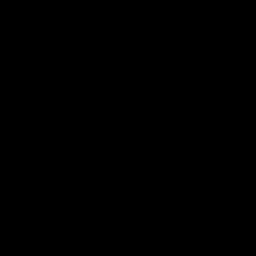

In [ ]:
net=UNet(256).cuda()

weights='params/unet.pth'
if os.path.exists(weights):
    net.load_state_dict(torch.load(weights))
    print('successfully')
else:
    print('no loading')

_input=input('please input JPEGImages path:') #data/JPEGImages/000007.jpg

img=keep_image_size_open_rgb(_input)
img_data=transform(img).cuda()
print(img_data.shape)
img_data=torch.unsqueeze(img_data,dim=0)
net.eval()
out=net(img_data)
out=torch.argmax(out,dim=1)
out=torch.squeeze(out,dim=0)
out=out.unsqueeze(dim=0)
print(set((out).reshape(-1).tolist()))
out=(out).permute((1,2,0)).cpu().detach().numpy()
cv2.imwrite('result/result.png',out)
from google.colab.patches import cv2_imshow
cv2_imshow(out*255.0)
#cv2.imshow('out',out*255.0)
#cv2.waitKey(0)